In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('walmart_stock.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2012-01-03,59.970001,61.060001,59.869999,60.330002,12668800,52.619235
1,2012-01-04,60.209999,60.349998,59.470001,59.709999,9593300,52.078475
2,2012-01-05,59.349998,59.619999,58.369999,59.419998,12768200,51.825539
3,2012-01-06,59.419998,59.450001,58.869999,59.000000,8069400,51.459220
4,2012-01-09,59.029999,59.549999,58.919998,59.180000,6679300,51.616215


In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.set_index('Date',inplace=True)

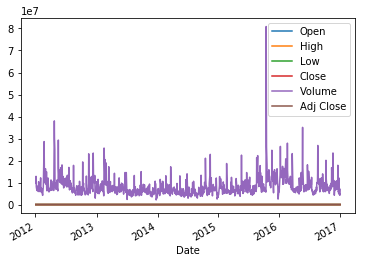

In [7]:
df.plot()

In [8]:
timeseries = df['Open']

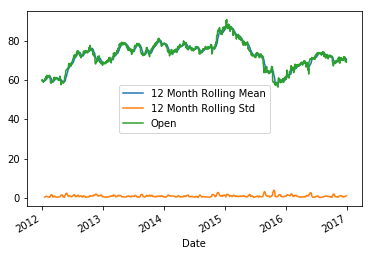

In [9]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

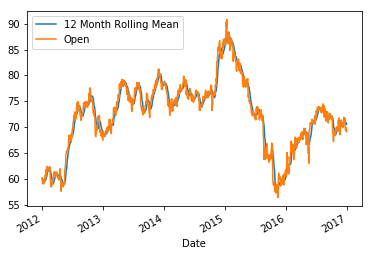

In [10]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

<Figure size 432x288 with 0 Axes>

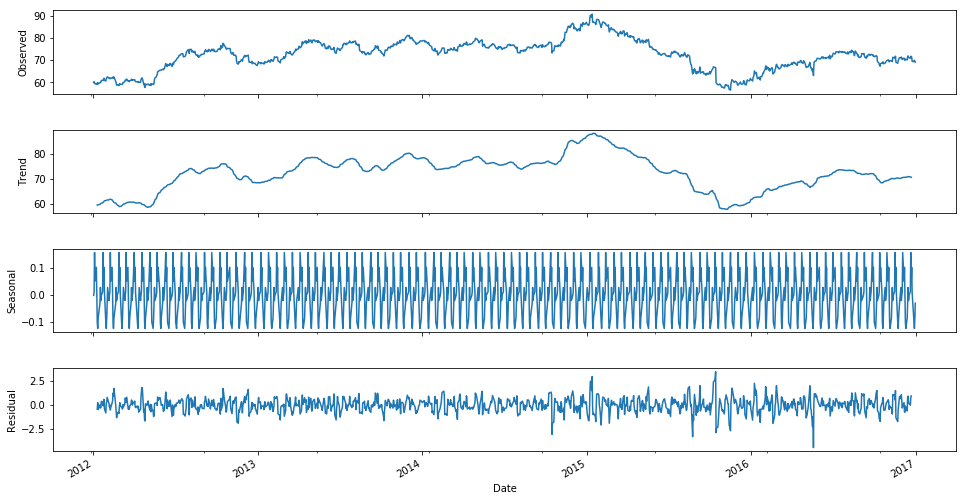

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Open'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Dicky Fuller test

We can use the Augmented [Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) [unit root test](https://en.wikipedia.org/wiki/Unit_root_test).

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, we are trying to whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

Let's run the Augmented Dickey-Fuller test on our data:

In [12]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
adf_check(df['Open'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.315173149148315
p-value : 0.1671210162134677
#Lags Used : 11
Number of Observations Used : 1246
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


## Important Note!

** We have now realized that our data is seasonal (it is also pretty obvious from the plot itself). This means we need to use Seasonal ARIMA on our model. If our data was not seasonal, it means we could use just ARIMA on it. We will take this into account when differencing our data! Typically financial stock data won't be seasonal, but that is kind of the point of this section, to show you common methods, that won't work well on stock finance data!**

## Differencing

The first difference of a time series is the series of changes from one period to the next. We can do this easily with pandas. You can continue to take the second difference, third difference, and so on until your data is stationary.

In [16]:
df['Open First Difference'] = df['Open'] - df['Open'].shift(1)

In [17]:
df['Open First Difference'].head()

Date
2012-01-03         NaN
2012-01-04    0.239998
2012-01-05   -0.860001
2012-01-06    0.070000
2012-01-09   -0.389999
Name: Open First Difference, dtype: float64

In [18]:
adf_check(df['Open First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -10.395143169790536
p-value : 1.9741449125945693e-18
#Lags Used : 10
Number of Observations Used : 1246
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


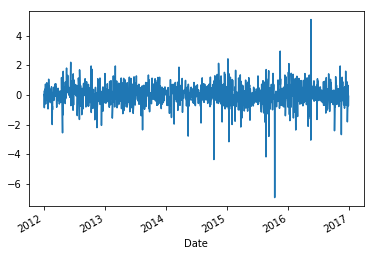

In [19]:
df['Open First Difference'].plot()

# Autocorrelation and Partial Autocorrelation Plots

An autocorrelation plot (also known as a [Correlogram](https://en.wikipedia.org/wiki/Correlogram) ) shows the correlation of the series with itself, lagged by x time units. So the y axis is the correlation and the x axis is the number of time units of lag.

So imagine taking your time series of length T, copying it, and deleting the first observation of copy #1 and the last observation of copy #2. Now you have two series of length T−1 for which you calculate a correlation coefficient. This is the value of of the vertical axis at x=1x=1 in your plots. It represents the correlation of the series lagged by one time unit. You go on and do this for all possible time lags x and this defines the plot.

You will run these plots on your differenced/stationary data. There is a lot of great information for identifying and interpreting ACF and PACF [here](http://people.duke.edu/~rnau/arimrule.htm) and [here](https://people.duke.edu/~rnau/411arim3.htm).

### Autocorrelation Interpretation

The actual interpretation and how it relates to ARIMA models can get a bit complicated, but there are some basic common methods we can use for the ARIMA model. Our main priority here is to try to figure out whether we will use the AR or MA components for the ARIMA model (or both!) as well as how many lags we should use. In general you would use either AR or MA, using both is less common.

* If the autocorrelation plot shows positive autocorrelation at the first lag (lag-1), then it suggests to use the AR terms in relation to the lag

* If the autocorrelation plot shows negative autocorrelation at the first lag, then it suggests using MA terms.

_____
### <font color='red'> Important Note! </font> 

Here we will be showing running the ACF and PACF on multiple differenced data sets that have been made stationary in different ways, typically you would just choose a single stationary data set and continue all the way through with that.

The reason we use two here is to show you the two typical types of behaviour you would see when using ACF.
_____

In [20]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

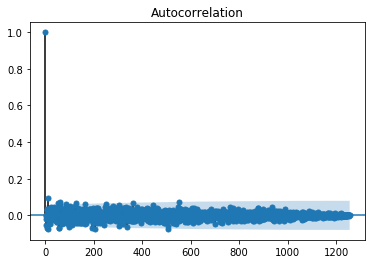

In [23]:
fig_first = plot_acf(df["Open First Difference"].dropna())

## Partial Autocorrelation

In general, a partial correlation is a conditional correlation.

It is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables.

For instance, consider a regression context in which y = response variable and x1, x2, and x3 are predictor variables.  The partial correlation between y and x3 is the correlation between the variables determined taking into account how both y and x3 are related to x1 and x2.

Formally, this is relationship is defined as:

## $\frac{\text{Covariance}(y, x_3|x_1, x_2)}{\sqrt{\text{Variance}(y|x_1, x_2)\text{Variance}(x_3| x_1, x_2)}}$

Check out this [link](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm) for full details on this.

D:\anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


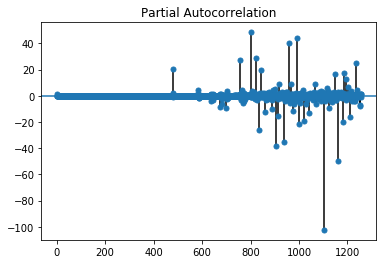

In [24]:
result = plot_pacf(df["Open First Difference"].dropna())

_____
### Final ACF and PACF Plots

We've run quite a few plots, so let's just quickly get our "final" ACF and PACF plots. These are the ones we will be referencing in the rest of the notebook below.
_____

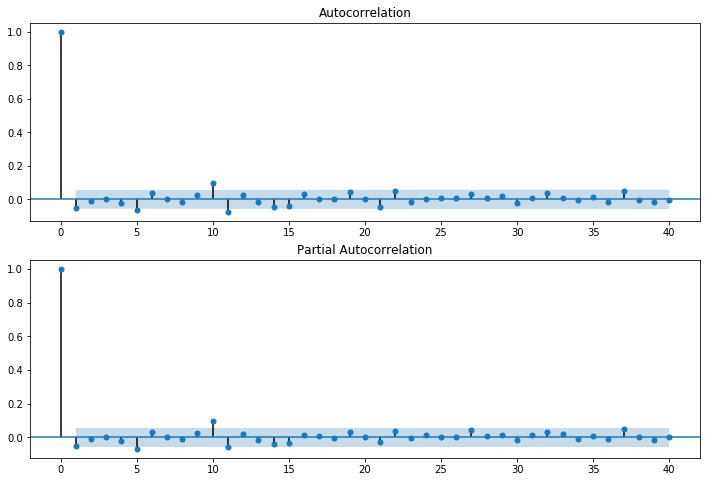

In [26]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Open First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Open First Difference'].iloc[13:], lags=40, ax=ax2)

In [27]:
# For non-seasonal data
from statsmodels.tsa.arima_model import ARIMA

In [28]:
# I recommend you glance over this!

# 
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array-like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |  If exogenous variables are given, then the model that is fit is
 

### p,d,q parameters

* p: The number of lag observations included in the model.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

p: the number before the first inverted bar in the ACF (we begin counting from 0)
d: the number of times we differenced our time series to achieve stationarity
q: the number before the first inverted bar in our PACF (we begin counting from 0)

In [30]:
# We have seasonal data!(P,D,Q,S)
model = sm.tsa.statespace.SARIMAX(df['Open'],order=(0,1,0), seasonal_order=(0,1,0,12))
results = model.fit()
print(results.summary())

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                               Open   No. Observations:                 1258
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1827.327
Date:                            Sun, 07 Oct 2018   AIC                           3656.654
Time:                                    23:16:03   BIC                           3661.781
Sample:                                         0   HQIC                          3658.581
                                           - 1258                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.1025      0.025     44.135      0.000       1.054       1.151
Ljung-Box (Q):                     

In [31]:
df.tail()

,Open,High,Low,Close,Volume,Adj Close,Open First Difference
Date,,,,,,,
2016-12-23,69.430000,69.750000,69.360001,69.540001,4803900,69.032411,-1.809998
2016-12-27,69.300003,69.820000,69.250000,69.699997,4435700,69.191240,-0.129997
2016-12-28,69.940002,70.000000,69.260002,69.309998,4875700,68.804087,0.639999
2016-12-29,69.209999,69.519997,69.120003,69.260002,4298400,68.754456,-0.730003
2016-12-30,69.120003,69.430000,68.830002,69.120003,6889500,68.615479,-0.089996


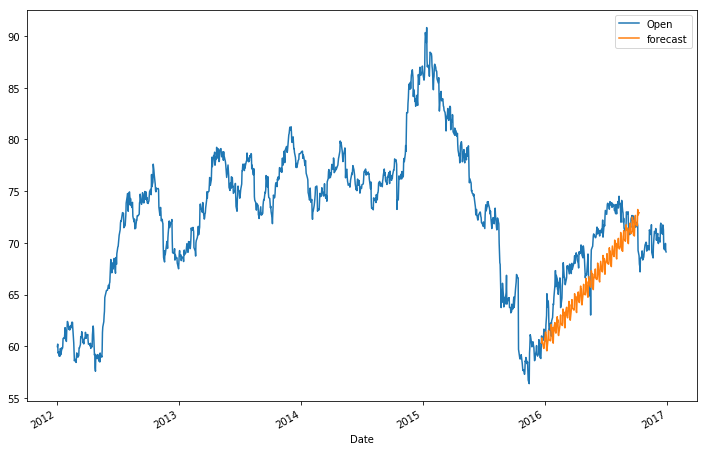

In [36]:
df['forecast'] = results.predict(start = 1000, end= 1200, dynamic= True)  
df[['Open','forecast']].plot(figsize=(12,8))